In [1]:
import os, sys, string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import pickle
from importlib import reload
import csv
import ROOT
from array import array

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.28/00
Success


## Reading in files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":245,
          "Load_standard":True, #bkgs
          "Load_lepton_signal":True,
          "Load_lepton_dirac":False,
          "Load_pi0_signal":False,
          "Load_pi0_dirac":False,
          "Load_DetVars":False, #This is for overlay
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False, #Don't do here, but in seperate script
          'Load_pi0_signal_DetVars':False, #Don't do here, but in seperate script
          "Load_data":True,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":True,
          "Use_logit":True,
          "nbins":5} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

samples = Functions.create_test_samples_list(Params)

if Params["Load_pi0_signal"] == True:
    pi0_sample_strings = [] #Unfortunately need to make, to discriminate lepton final states from pi0 final states for signal
    for pi0_point in Constants.HNL_mass_pi0_samples:
        pi0_sample_strings += [str(pi0_point)+"_pi0"]
        
if (Params["Load_lepton_signal"] == True) or (Params["Load_lepton_dirac"] == True): loc = "bdts/"
else: loc = "bdts/pi0_selection/"
        
# end_string = "_FINAL"
end_string = "_full_Finished"


Loading these run1 samples: 
['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee', 'beamgood']


In [3]:
def Load_preselected_pkls(samples, Params, loc_pkls, filename, Test_filename):
    """
    For loading in preselected pkl files, including BDT test pkls. 
    """
    sample_test_dict = {}
    # sig_names_list = Constants.HNL_ee_samples_names+Constants.HNL_mass_pi0_samples_names+Constants.HNL_ee_dirac_names+Constants.HNL_pi0_dirac_names
    sig_names_list = Constants.HNL_ee_samples_names
    if Params["Load_DetVars"] == True: loc_pkls += "DetVars/"
    elif Params["Load_Signal_DetVars"] == True: loc_pkls += "Signal_DetVars/"
    elif Params['Load_pi0_signal_DetVars'] == True: loc_pkls += "Signal_DetVars/pi0/"
    
    for sample in samples:
        if (sample == "overlay") or (sample in sig_names_list): start_str = loc_pkls + "BDT_Test_dfs/Test_"
        elif (sample == "beamoff") and (Params["EXT_in_training"] == True): start_str = loc_pkls + "BDT_Test_dfs/Test_"
        elif sample in Constants.HNL_mass_pi0_samples_names: start_str = loc_pkls + "BDT_Test_dfs/pi0_selection/Test_"
        else: start_str = loc_pkls + "Preselected_"
        # sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+f"_flattened{filename}.pkl")
        if ((sample == "beamoff") or (sample == "overlay") or (sample in sig_names_list)) and Params["EXT_in_training"]==True:
            sample_test_dict[sample] = pd.read_pickle(start_str+f"{sample}_"+Params["Run"]+f"_flattened{Test_filename}.pkl")
        else:
            sample_test_dict[sample] = pd.read_pickle(start_str+f"{sample}_"+Params["Run"]+f"_flattened{filename}.pkl")
    
    return sample_test_dict


In [4]:
sample_test_dict = Load_preselected_pkls(samples, Params, loc_pkls, end_string, "_full_Finished")

In [5]:
sample_test_dict.keys()

dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee', 'beamgood'])

In [6]:
def Load_BDT_models(sample_dict, Params, BDT_name):
    """
    Load variable list then loads BDT models for samples.
    """
    if (Params["Load_lepton_signal"] == True) or (Params["Load_lepton_dirac"] == True): loc = "bdts/"
    else: loc = "bdts/pi0_selection/"
    
    with open(loc+f"input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
    
    bdt_vars = saved_variables
    xgb_test_dict = {}
    
    for sample in sample_dict:
        xgb_test_dict[sample] = xgboost.DMatrix(sample_dict[sample][bdt_vars])
    
    if Params["Load_lepton_signal"] == True: signal_names = Constants.HNL_ee_samples_names
    elif Params["Load_pi0_signal"] == True: signal_names = Constants.HNL_mass_pi0_samples_names
    # elif Params["Load_lepton_dirac"] == True: signal_names = Constants.HNL_ee_dirac_names
    elif Params["Load_lepton_dirac"] == True: signal_names = ["10_ee", "100_ee", "150_ee"] #Using Majorana models currently
    # elif Params["Load_pi0_dirac"] == True: signal_names = Constants.HNL_pi0_dirac_names
    elif Params["Load_pi0_dirac"] == True: signal_names = ["150_pi0", "200_pi0", "245_pi0"]
    elif Params["Load_single_file"] == True: signal_names = Params["single_file"]
    
    for HNL_mass in signal_names:
        # bdt = xgboost.Booster()
        filename = loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.pkl"
        bdt = pickle.load(open(file_name, "rb"))
        mass_val = int(HNL_mass.split("_")[0])
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_dict[sample][f"BDT_output_{mass_val}MeV"] = results

    return sample_dict

def OLD_Load_BDT_models(sample_dict, Params, BDT_name):
    """
    Load variable list then loads BDT models for samples, using the older .json way of saving.
    """
    if (Params["Load_lepton_signal"] == True) or (Params["Load_lepton_dirac"] == True): loc = "bdts/"
    else: loc = "bdts/pi0_selection/"
    
    with open(loc+f"input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
    
    bdt_vars = saved_variables
    xgb_test_dict = {}
    
    for sample in sample_dict:
        xgb_test_dict[sample] = xgboost.DMatrix(sample_dict[sample][bdt_vars])
    
    if Params["Load_lepton_signal"] == True: signal_names = Constants.HNL_ee_samples_names
    elif Params["Load_pi0_signal"] == True: signal_names = Constants.HNL_mass_pi0_samples_names
    # elif Params["Load_lepton_dirac"] == True: signal_names = Constants.HNL_ee_dirac_names
    elif Params["Load_lepton_dirac"] == True: signal_names = ["10_ee", "100_ee", "150_ee"] #Using Majorana models currently
    # elif Params["Load_pi0_dirac"] == True: signal_names = Constants.HNL_pi0_dirac_names
    elif Params["Load_pi0_dirac"] == True: signal_names = ["150_pi0", "200_pi0", "245_pi0"]
    elif Params["Load_single_file"] == True: signal_names = Params["single_file"]
    
    for HNL_mass in signal_names:
        bdt = xgboost.Booster()
        bdt.load_model(loc+Params["Run"]+f"_{HNL_mass}{BDT_name}.json")
        mass_val = int(HNL_mass.split("_")[0])
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_dict[sample][f"BDT_output_{mass_val}MeV"] = results

    return sample_dict


In [7]:
# sample_test_dict = Load_BDT_models(sample_test_dict, Params, "_full_Finished")
sample_test_dict = OLD_Load_BDT_models(sample_test_dict, Params, "_full_Finished")

# sample_test_dict = Load_BDT_models(sample_test_dict, Params, end_string)

print(sample_test_dict.keys())

dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee', 'beamgood'])


## Checking max BDT score (for logit transformation)

In [8]:
reload(Constants)
if Params["Load_lepton_signal"] == True: 
    HNL_masses = Constants.HNL_mass_samples
    sample_names = Constants.HNL_ee_samples_names
if Params["Load_pi0_signal"] == True: 
    HNL_masses = Constants.HNL_mass_pi0_samples
    sample_names = Constants.HNL_mass_pi0_samples_names
if Params["Load_lepton_dirac"] == True: 
    HNL_masses = Constants.HNL_ee_dirac_mass_samples
    sample_names = Constants.HNL_ee_dirac_names
if Params["Load_pi0_dirac"] == True: 
    HNL_masses = Constants.HNL_pi0_dirac_mass_samples
    sample_names = Constants.HNL_pi0_dirac_names
elif Params["Load_single_file"] == True: HNL_masses = [Params["single_file"]]

max_scores, min_scores = [], []
for HNL_mass in HNL_masses:
    if Params["Load_lepton_signal"] == True:
        max_scores.append(max(Functions.logit(sample_test_dict[str(HNL_mass)+"_ee"][f"BDT_output_{HNL_mass}MeV"])))
        min_scores.append(min(Functions.logit(sample_test_dict["overlay"][f"BDT_output_{HNL_mass}MeV"])))
    if Params["Load_pi0_signal"] == True:
        max_scores.append(max(Functions.logit(sample_test_dict[str(HNL_mass)+"_pi0"][f"BDT_output_{HNL_mass}MeV"])))
        min_scores.append(min(Functions.logit(sample_test_dict["overlay"][f"BDT_output_{HNL_mass}MeV"])))
    if Params["Load_lepton_dirac"] == True:
        max_scores.append(max(Functions.logit(sample_test_dict[str(HNL_mass)+"_ee_dirac"][f"BDT_output_{HNL_mass}MeV"])))
        min_scores.append(min(Functions.logit(sample_test_dict["overlay"][f"BDT_output_{HNL_mass}MeV"])))
    if Params["Load_pi0_dirac"] == True:
        max_scores.append(max(Functions.logit(sample_test_dict[str(HNL_mass)+"_pi0_dirac"][f"BDT_output_{HNL_mass}MeV"])))
        min_scores.append(min(Functions.logit(sample_test_dict["overlay"][f"BDT_output_{HNL_mass}MeV"])))
    
max_all_scores = max(max_scores)
min_all_scores = min(min_scores)
print("Maximum score for all signal samples is " + str(max_all_scores))
print("Minimum score for all signal samples is " + str(min_all_scores))                     

max_score_int = np.ceil(max_all_scores)
min_score_int = np.floor(min_all_scores)
print("Maximum integer for bins is " + str(max_score_int))
print("Minimum integer for bins is " + str(min_score_int))

Maximum score for all signal samples is 8.136006355285645
Minimum score for all signal samples is -11.04528522491455
Maximum integer for bins is 9.0
Minimum integer for bins is -12.0


In [9]:
if Params["Load_Signal_DetVars"] == True: max_score_int = 7.0

In [10]:
print(HNL_masses)

[2, 10, 20, 50, 100, 150]


## Merging bins with zero bkg prediction

In [11]:
#Checking which bins to merge Need to properly write this
merged_bins_dict, bin_cents = {}, {}
# min_score_cut = -5.0
min_score_cut = min_score_int
xlims = [min_score_cut,max_score_int]
nbins = int(xlims[1]-xlims[0])
min_overlay = 3 #The threshold of minimum overlay events required in a bin, used to be 1
print("Initial nbins is " + str(nbins))
print("With range of " + str(xlims))
print(f"Requiring more than {min_overlay} overlay events in each bin")

for HNL_mass in HNL_masses:
    bins_list = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'],bins=nbins,range=xlims)[1]
    if Params["Use_logit"] == True:
        bkg_scores=[Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),
                    Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),
                    Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'])]
    totbkg=np.histogram(bkg_scores[0],bins=nbins,range=xlims)[0]+np.histogram(bkg_scores[1],bins=nbins,range=xlims)[0]+np.histogram(bkg_scores[2],bins=nbins,range=xlims)[0]
    offbkg=np.histogram(bkg_scores[2],bins=nbins,range=xlims)[0]
    overlaybkg=np.histogram(bkg_scores[0],bins=nbins,range=xlims)[0]
    dirtbkg=np.histogram(bkg_scores[1],bins=nbins,range=xlims)[0]
    bins_new=[]
    for i,bin_bkg in enumerate(totbkg):
        if(overlaybkg[i]>min_overlay): #Checking if unweighted overlay bkg has at least one event in the bin
            bins_new.append(bins_list[i])

    bins_new.append(bins_list[-1])
    merged_bins_dict[HNL_mass] = bins_new
    bin_cents[HNL_mass] = (np.array(bins_new[:-1])+np.array(bins_new[1:]))/2
    
    

Initial nbins is 21
With range of [-12.0, 9.0]
Requiring more than 3 overlay events in each bin


## Plotting BDT outputs

In [12]:
#Need to add dirac samples into plot dict here

In [13]:
BDT_name = end_string

path_training_fracs = loc+f"Training_fractions/{BDT_name}_"+Params["Run"]

if(os.path.exists(path_training_fracs)):
    with open(path_training_fracs, "rb") as fp:   # Unpickling
        saved_train_fracs = pickle.load(fp)
else:
    print("No training fractions saved for this BDT model.\nUsing defaults of overlay=0.7, signal=0.7, EXT=0.3 and dirt=0.0")
    saved_train_fracs = {"overlay":0.7, "signal":0.7, "beamoff":0.3, "dirtoverlay":0.0}
    
sample_norms = Functions.Get_weighted_sample_norms(Params, sample_test_dict, sample_names, saved_train_fracs["overlay"], saved_train_fracs["signal"], 
                                          saved_train_fracs["beamoff"], saved_train_fracs["dirtoverlay"])

samples_plot={'overlay_test':sample_test_dict['overlay'],
              'dirtoverlay':sample_test_dict['dirtoverlay'],
              'beamoff':sample_test_dict['beamoff']}

#Update with signal dfs too.
for signal_name in sample_names:
    samples_plot.update({signal_name:sample_test_dict[signal_name]})
    
print(samples_plot.keys())
print(sample_norms.keys())

No training fractions saved for this BDT model.
Using defaults of overlay=0.7, signal=0.7, EXT=0.3 and dirt=0.0
dict_keys(['overlay_test', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])
dict_keys(['overlay_test', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])


In [14]:
def make_overflow_bin(bins_dict, bins_cents_dict):
    """
    For making the final "overflow" bin the same size as the previous bins, i.e one integer in width.
    """
    bins_overflow, bins_cent_overflow = {}, {}
    for HNL_mass in bins_dict:
        overflow_bin = bins_cents_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin centre val. 
        bins_cent_overflow[HNL_mass] = bins_cents_dict[HNL_mass].copy()
        bins_cent_overflow[HNL_mass][-1] = overflow_bin
        bins_overflow[HNL_mass] = bins_dict[HNL_mass].copy()
        bins_overflow[HNL_mass][-1] = bins_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin end val. 
    return bins_overflow, bins_cent_overflow

bins_overflow, bins_cents_overflow = make_overflow_bin(merged_bins_dict, bin_cents)

def make_xlims_dict(bins_dict, spacing, lower = None):
    """
    Making a dict of xlims for plotting several mass points at once.
    Also returns a dict of xticks for the purpose of indicating the overflow.
    """
    xlims_adjusted, xticks_adjusted = {}, {}
    vals_dict={}
    for HNL_mass in bins_dict:
        if isinstance(lower,(int, float)): lower_val = lower
        else: lower_val = bins_dict[HNL_mass][0]
        xlims_adjusted[HNL_mass] = [lower_val,bins_dict[HNL_mass][-1]]
        ticks = np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], spacing)
        if ticks[-1] != bins_dict[HNL_mass][-2]: ticks = np.append(ticks, bins_dict[HNL_mass][-1]-1)
        ticks_strings = []
        vals = []
        for val in ticks:
            ticks_strings.append(str(int(val)))
            vals.append(val)
        ticks_strings[-1] = str(ticks_strings[-1])+"+"
        xticks_adjusted[HNL_mass] = ticks_strings
        vals_dict[HNL_mass] = vals
        
    return xlims_adjusted, xticks_adjusted, vals_dict

xlims_dict, xticks_dict, vals_dict = make_xlims_dict(bins_overflow, 2)

xlims=[min_score_int,max_score_int]    
BINS = int(xlims[1]-xlims[0])


In [15]:
HNL_scale = 0.1

for sig_name in sample_names:
    HNL_mass = int(sig_name.split("_")[0])
    theta_original = Constants.theta_mu_4_dict[HNL_mass]
    theta_squared = theta_original**2
    POT_scaling = Constants.run1_POT_scaling_dict[sig_name]
    plotted_scaling = HNL_scale
    
    theta_scaling_4 = POT_scaling/plotted_scaling 
    theta_scaling_2 = np.sqrt(theta_scaling_4)
    
    approx_theta_squared = theta_squared/theta_scaling_2
    
    print(sig_name)
    print(approx_theta_squared)
    

2_ee
11.853835449993682
10_ee
0.04755871803012034
20_ee
0.006094504203787012
50_ee
0.00033754949995811335
100_ee
3.454371689721344e-05
150_ee
7.91956006366839e-06


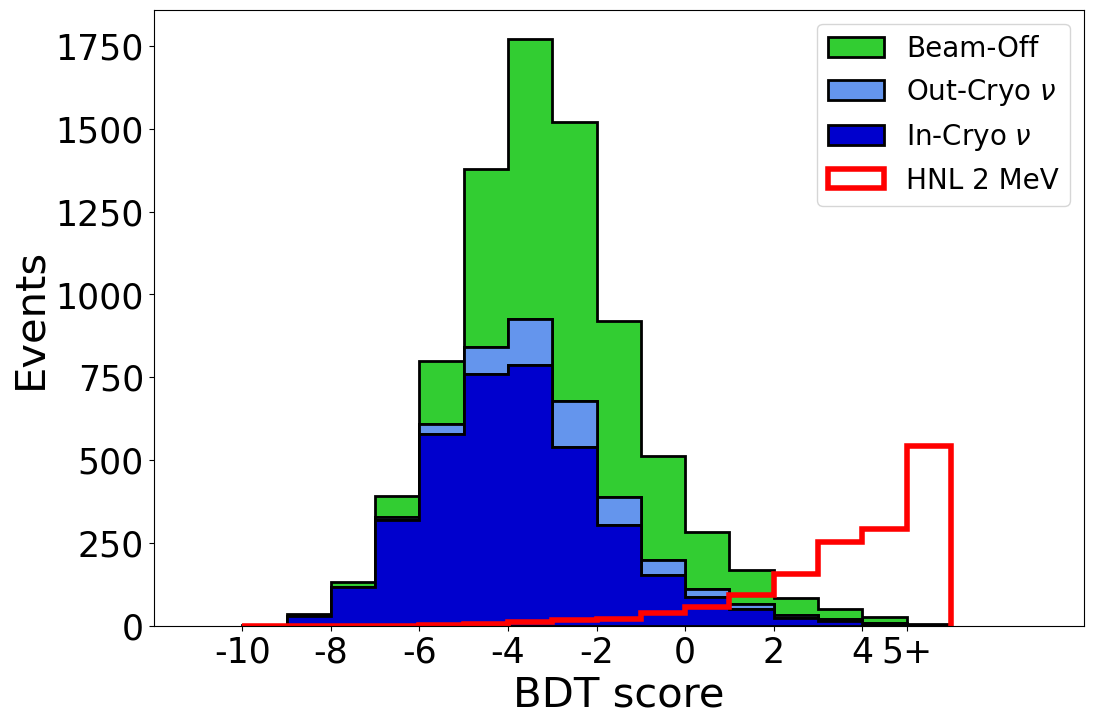

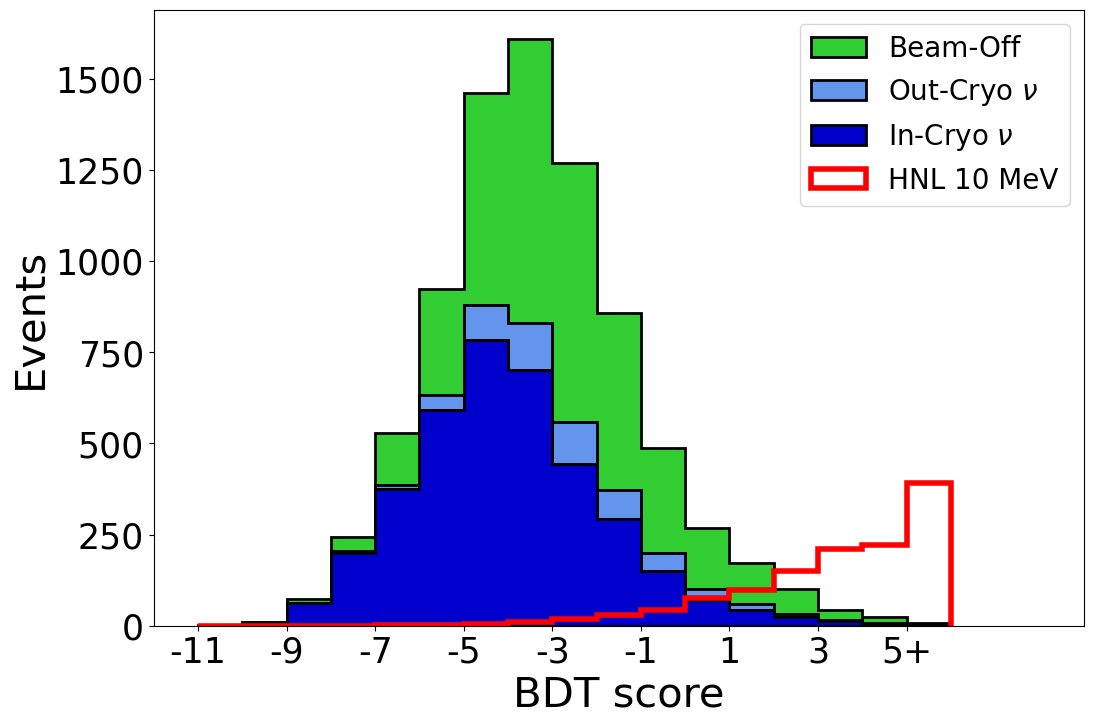

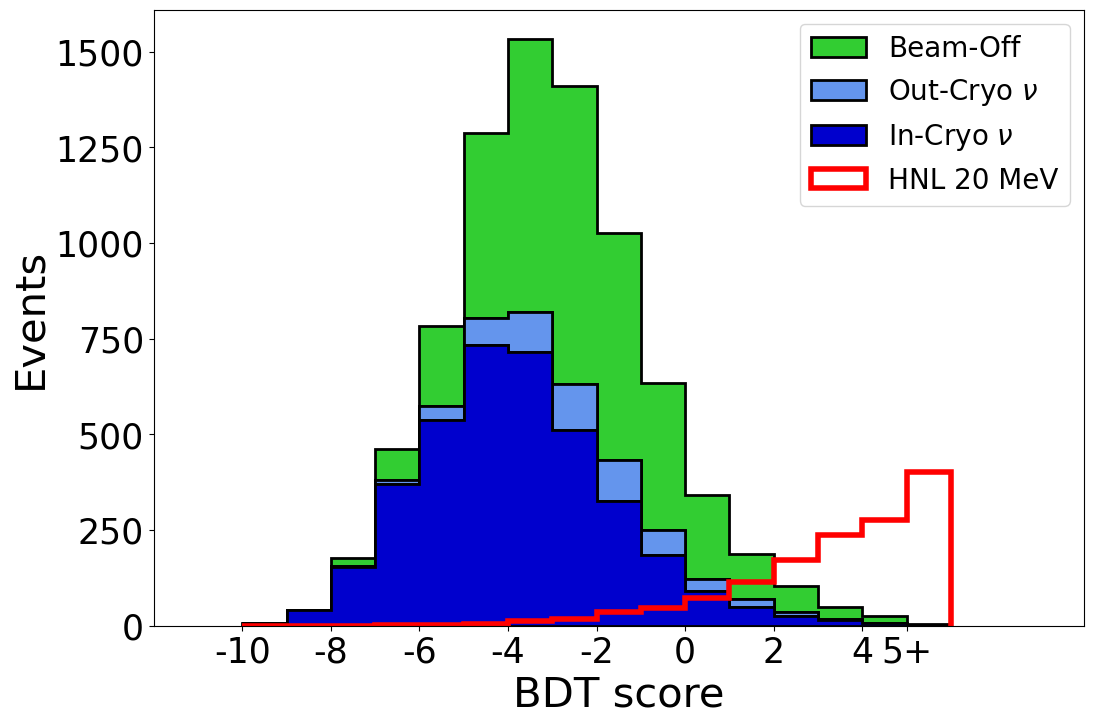

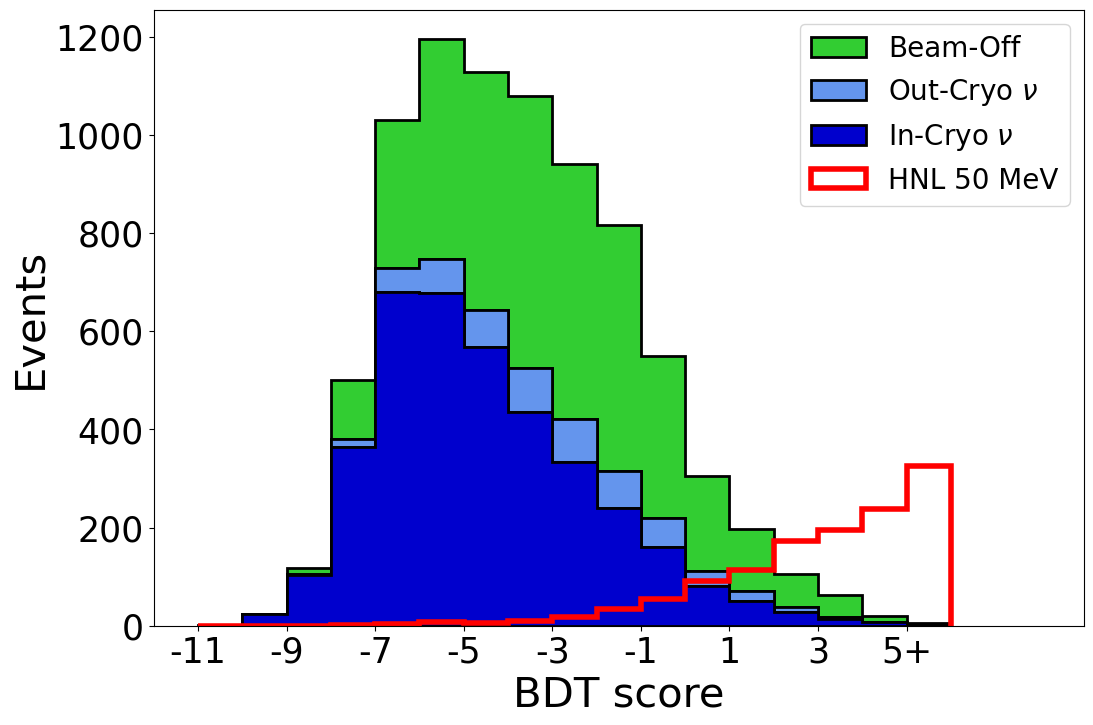

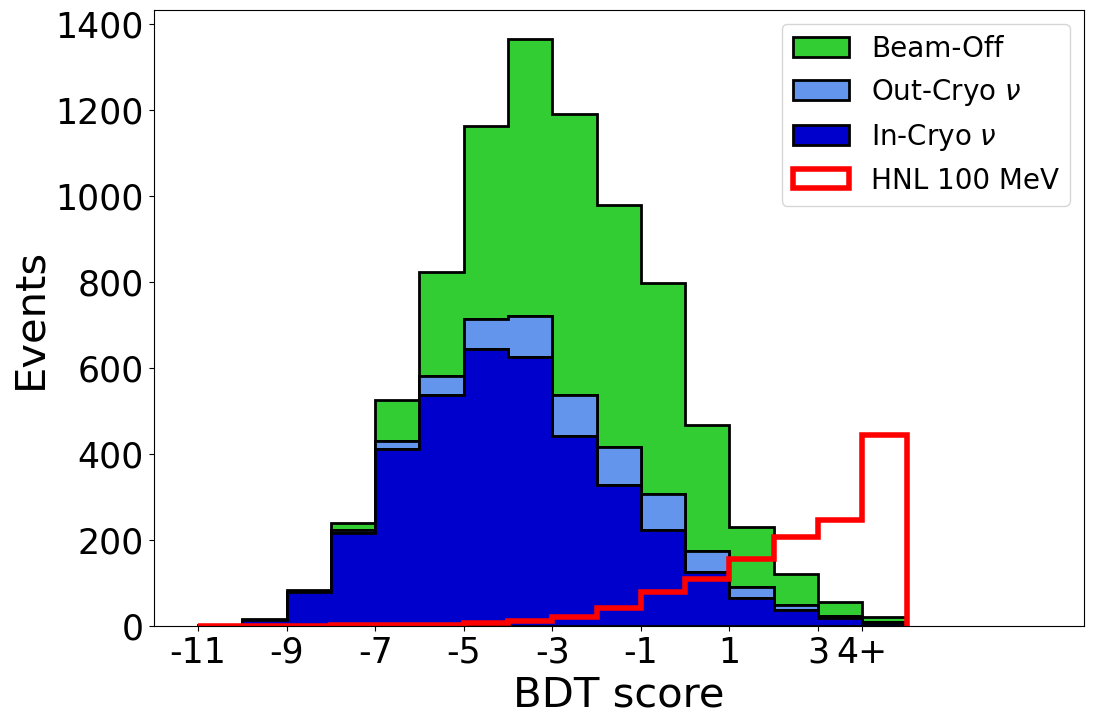

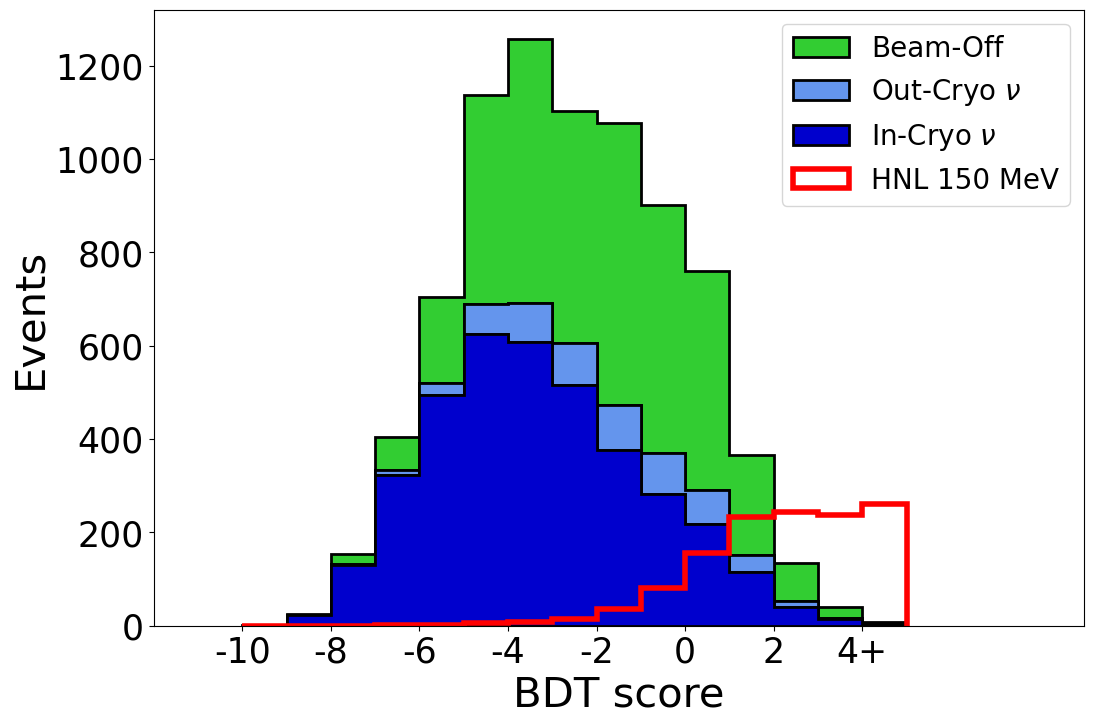

In [16]:
reload(PT)   
# HNL_scale = 0.1

PT.Plot_BDT_output(HNL_masses=HNL_masses, signal_names=sample_names, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
                   bins_cent_dict=bins_cents_overflow, bins_dict=bins_overflow, bins_original=merged_bins_dict,
                   xticks=xticks_dict, xticks_vals=vals_dict,figsize=[12,8], MergeBins=True, density=False, legloc="best",logy=False, savefig=True, 
                   save_str = "_full_Finished", Run=Params["Run"], logit = Params["Use_logit"],legsize=20, HNL_scale=HNL_scale)

## Saving BDT output to .root files

In [ ]:
def Save_one_hist(hist,name,nbins,xlims):
    tData = ROOT.TH1F(name,name,len(nbins)-1,array("d",nbins))
    for i in range(len(nbins)-1):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,theta,fileName='test.root'): 
    rFile = ROOT.TFile(f'{fileName}','RECREATE')
    tData = ROOT.TH1F("theta","theta",1,array("d",[0,1]))
    tData.SetBinContent(1,theta)
    rFile.Write()
    for i, name in enumerate(hist_samples):
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF): #This doesn't take the weights into account, assumes they average to 1.0
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

def make_stat_err_true(var, bins, weights_times_SF): #Saved in Functions.py
    hist_unweighted = np.histogram(var,bins=bins)[0]
    hist_weighted = np.histogram(var,bins=bins,weights=weights_times_SF)[0]
    Total_SF = np.nan_to_num(hist_weighted/hist_unweighted)
    stat_err = np.sqrt(hist_unweighted)*Total_SF
    return stat_err

def make_stat_err_new(var, bins, weights_times_SF): 
    hist_squared = np.histogram(var,bins=bins,weights=weights_times_SF**2)[0]
    stat_err=np.sqrt(hist_squared)
    return stat_err

def SF_times_weights(sample_dict, sample, Run, SF_test, SF_signal):
    if Run == "run1": POT_norm = Constants.run1_POT_scaling_dict
    if Run == "run3": POT_norm = Constants.run3_POT_scaling_dict
    
    if sample == 'overlay': SF = sample_dict[sample]['weight']*POT_norm[sample]*SF_test
    elif sample == 'dirtoverlay': SF = sample_dict[sample]['weight']*POT_norm[sample]
    elif (sample == 'beamoff') or (sample =='beamgood'): SF = np.ones(len(sample_dict[sample][f'run']))*POT_norm[sample]
    else: 
        SF = np.ones(len(sample_dict[str(sample)+"_pi0"][f'BDT_output_{sample}MeV']))*(POT_norm[sample]*SF_test*SF_signal)
    return SF

def SF_times_weights_pi0(sample_dict, sample, Run, SF_test, SF_signal):
    if Run == "run1": POT_norm = Constants.run1_POT_scaling_dict
    if Run == "run3": POT_norm = Constants.run3_POT_scaling_dict
    
    if sample == 'overlay': SF = sample_dict[sample]['weight']*POT_norm[sample]*SF_test
    elif sample == 'dirtoverlay': SF = sample_dict[sample]['weight']*POT_norm[sample]
    elif (sample == 'beamoff') or (sample =='beamgood'): SF = np.ones(len(sample_dict[sample][f'run']))*POT_norm[sample]
    else: 
        SF = np.ones(len(sample_dict[str(sample)+"_pi0"][f'BDT_output_{sample}MeV']))*(POT_norm[str(sample)+"_pi0"]*SF_test*SF_signal)
    return SF

def SF_times_weights_sample_names(sample_dict, sample, HNL_mass, Run, SF_test, SF_signal):
    if Run == "run1": POT_norm = Constants.run1_POT_scaling_dict
    if Run == "run3": POT_norm = Constants.run3_POT_scaling_dict
    
    if sample == 'overlay': SF = sample_dict[sample]['weight']*POT_norm[sample]*SF_test
    elif sample == 'dirtoverlay': SF = sample_dict[sample]['weight']*POT_norm[sample]
    elif (sample == 'beamoff') or (sample =='beamgood'): SF = np.ones(len(sample_dict[sample][f'run']))*POT_norm[sample]
    else: 
        SF = np.ones(len(sample_dict[sample][f'BDT_output_{HNL_mass}MeV']))*(POT_norm[sample]*SF_test*SF_signal)
    return SF

## Saving BDT output for reweighting systematics plots

In [ ]:
merged_bins_dict.keys()

In [ ]:
pkl_results_loc = "pkl_files/"+Params["Run"]+"/current_files/Results/"
if Params["Load_pi0_signal"] == True: pkl_results_loc += "pi0/"

# print(sample_test_dict['overlay'].keys())
if Params["EXT_in_training"]==True:
    save_name = f"_EXT{end_string}"
if Params["EXT_in_training"]==False:
    save_name = f"{end_string}"
    
print_vals = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if print_vals == "y":
    
    columns = Variables.event_vars + Variables.weight_related + ["weight"]
    for HNL_mass in merged_bins_dict:
        columns.append(f'BDT_output_{HNL_mass}MeV')
    print(columns)
    
    overlay_to_save = sample_test_dict['overlay'][columns].copy()
    #df2 = overlay_merged_to_save.loc[:,~overlay_merged_to_save.columns.duplicated()] #Getting rid of duplicate "weight" column
    #df2.to_pickle(pkl_results_loc + "overlay_results.pkl")
    overlay_to_save.to_pickle(pkl_results_loc + f"overlay_results{save_name}.pkl")
    
    print(overlay_to_save.keys())
    
    print(pkl_results_loc + f"overlay_results{save_name}.pkl")

## Using sample_names

In [ ]:
merged_bins_dict.keys()

In [ ]:
# SCALE_UP_dict = {2:5,10:5,20:200,50:50,100:10,150:5,180:4,200:4,220:4,240:4,245:4} #Doing this because the scale factor used in pyhf is bounded
SCALE_UP_dict = {2:1.0,10:1.0,20:1.0,50:1.0,100:1.0,150:1.0, 180:1.0, 200:1.0, 220:1.0, 240:1.0, 245:1.0}

new_theta_dict, dict_for_root = {}, {}

# if Params["Load_pi0_signal"] == True: exit() #This cell is for lepton samples

bkg_samples = []
for sample in samples:
    if isinstance(sample,str): bkg_samples.append(sample)

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)
if (Params["Load_lepton_dirac"]) or (Params["Load_pi0_dirac"]): SF_test=1.0 #Didn't train on these samples so don't scale up again. 

# name_type = "ee"
name_type = Functions.Get_signal_name_type(Params)

print("Saving minimum BDT score of " + str(merged_bins_dict[150][0]))

for i, HNL_mass in enumerate(HNL_masses):
    print(HNL_mass)
    sig_name = sample_names[i]
    original_theta = Constants.theta_mu_4_dict[HNL_mass]
    new_theta = original_theta*SCALE_UP_dict[HNL_mass]
    new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
    SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    
    bins = merged_bins_dict[HNL_mass]
    sample_list = bkg_samples + [sig_name]
    # if Params["Load_data"] == True: sample_list += ["beamgood"]
    for sample in sample_list:
        score = Functions.logit(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV'])
        SF_list = SF_times_weights_sample_names(sample_test_dict, sample, HNL_mass, Params["Run"], SF_test, SCALE_EVENTS)
        stat_err = make_stat_err_true(score, bins, SF_list) #Should generatlly use this
        # stat_err = make_stat_err_new(score, bins, SF_list)
        hist = np.histogram(score, bins=bins, weights=SF_list)
        dict_for_root[sample] = {'bins': np.array(hist[1]), 'hist': np.array(hist[0]), 'err': np.array(stat_err)}
        
    hist_samples = {"bkg_overlay":dict_for_root['overlay'],"bkg_dirt":dict_for_root['dirtoverlay'],
                    "bkg_EXT":dict_for_root['beamoff'],"signal":dict_for_root[sample]}
    if 'beamgood' in bkg_samples:
        hist_samples.update({"data":dict_for_root['beamgood']})
        
    # save_name = Params["Run"]+f"_{HNL_mass}MeV_{name_type}{end_string}.root"
    if Params["EXT_in_training"]==True:
        save_name = Params["Run"]+f"_{HNL_mass}_{name_type}_EXT{end_string}.root"
    if Params["EXT_in_training"]==False:
        save_name = Params["Run"]+f"_{HNL_mass}_{name_type}{end_string}.root"
    
    if (Params["Load_pi0_signal"]==True) or (Params["Load_pi0_dirac"]==True):
        SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="bdt_output/pi0/"+save_name)
        SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="Uncertainties/pi0/"+save_name)
    else:
        SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="bdt_output/"+save_name)
        SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="Uncertainties/"+save_name)
        
print("Saved all")
print(f"Saved with names like {save_name}")

## Calculating efficiency

In [32]:
sample_test_dict["overlay"]["weight"]

entry   subentry
639791  0           1.251226
639803  0           0.738358
639804  0           0.951365
639819  0           0.847589
639820  1           0.004604
                      ...   
914633  0           1.596181
914644  0           0.349880
914647  0           1.525194
914651  0           1.018703
914698  1           0.784818
Name: weight, Length: 13817, dtype: float32

In [33]:
def calculate_efficiency(df, file_name, Run, BDT_cutoff, HNL_mass, train_fracs, debug=False):
    if Run == "run1": ev_num_dict = Constants.run1_event_numbers
    if Run == "run3": ev_num_dict = Constants.run3_event_numbers
    
    train_vs_test_fraction = train_fracs[file_name] #Should be saved in in script 3.0
    norm = 1.0/(1-train_vs_test_fraction) #Need to scale up to account for events lost
    
    total_ev_num = len(df)
    ev_num_initial = ev_num_dict[file_name]
    cut_df = df.query(f"BDT_output_{HNL_mass}MeV > {BDT_cutoff}")
    new_ev_num = len(cut_df)
    
    efficiency = norm*(new_ev_num/ev_num_initial)
    
    if debug:
        print(f"Total events is {total_ev_num}")
        print(f"Events after cut is {new_ev_num}")   
    
    return efficiency

def calculate_ev_numbers(df, file_name, Run, BDT_cutoff, HNL_mass, train_fracs, debug=False):
    if Run == "run1": 
        ev_num_dict = Constants.run1_event_numbers
        POT_scaling_dict = Constants.run1_POT_scaling_dict
    if Run == "run3": 
        ev_num_dict = Constants.run3_event_numbers
        POT_scaling_dict = Constants.run3_POT_scaling_dict
        
    cut_df = df.query(f"BDT_output_{HNL_mass}MeV > {BDT_cutoff}")
    
    if file_name == "overlay" or file_name == "dirtoverlay":
        sum_weights = cut_df["weight"].sum()
    else: sum_weights = len(cut_df)
    
    Number_events = sum_weights*POT_scaling_dict[file_name]
    
    return Number_events
    

def sum_total_weights(df): #This is to check that the weighting doesn't affect the overall efficiency significantly (i.e av weight is approx 1)
    total_evs = len(df)
    sum_weights = df["weight"].sum()
    
    weight_per_ev = sum_weights/total_evs
    
    print(f"Sum of weights is {sum_weights}")
    print(f"Average weight is {weight_per_ev}")


In [41]:
print(sample_test_dict.keys())
# BDT_name = end_string
BDT_name = "_full_Finished_8"

if Params["Load_lepton_signal"]==True: loc = "bdts/"
if Params["Load_pi0_signal"]==True: loc = "bdts/pi0_selection/"

with open(loc+f"Training_fractions/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
    saved_train_fracs = pickle.load(fp)
    
# for sample in ['overlay', 'dirtoverlay', 'beamoff']: #sample_test_dict
for sample in sample_test_dict:
    if sample in Constants.HNL_ee_samples_names + Constants.HNL_mass_pi0_samples_names: 
        saved_train_fracs[sample] = saved_train_fracs["signal"]
    elif sample not in saved_train_fracs.keys(): saved_train_fracs[sample] = 0.0

print(saved_train_fracs)

dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee', 'beamgood'])
{'overlay': 0.5, 'signal': 0.5, 'beamoff': 0.5, 'dirtoverlay': 0.5, '2_ee': 0.5, '10_ee': 0.5, '20_ee': 0.5, '50_ee': 0.5, '100_ee': 0.5, '150_ee': 0.5, 'beamgood': 0.0}


In [42]:
Number_of_bins = 3

BDT_cut = {}

for sample in Constants.HNL_mass_samples:
    BDT_cut[sample] = Functions.invlogit(merged_bins_dict[sample][-1*Number_of_bins])
    
standard_BDT_cut = Functions.invlogit(BDT_cut[100])
print(BDT_cut)

{2: 0.9820137894920938, 10: 0.9820137894920938, 20: 0.9820137894920938, 50: 0.9820137894920938, 100: 0.9525741268980056, 150: 0.9525741268980056}


In [43]:
logit_BDT_cut = -20
# logit_BDT_cut = 2.0
standard_BDT_cut = Functions.invlogit(logit_BDT_cut)
print(f"Using a logit BDT cut of {logit_BDT_cut}, which corresponds to {standard_BDT_cut} in [0,1] BDT score.")

efficiency_dict = {}
Scaled_events_dict = {}

for file in Constants.HNL_ee_samples_names: #Just signal samples
# for file in sample_test_dict:
    HNL_mass_number = file.split("_")[0]
    print(file)
    efficiency_dict[file] = calculate_efficiency(sample_test_dict[file], file, Params["Run"], BDT_cut[int(HNL_mass_number)], HNL_mass_number,
                                                 saved_train_fracs, debug=True)
    Scaled_events_dict[file] = calculate_ev_numbers(sample_test_dict[file], file, Params["Run"], BDT_cut[int(HNL_mass_number)], HNL_mass_number,
                                                 saved_train_fracs, debug=True)


Using a logit BDT cut of -20, which corresponds to 2.0611536181902033e-09 in [0,1] BDT score.
2_ee
Total events is 4448
Events after cut is 2498
10_ee
Total events is 3779
Events after cut is 1835
20_ee
Total events is 4171
Events after cut is 2030
50_ee
Total events is 3811
Events after cut is 1692
100_ee
Total events is 3964
Events after cut is 2070
150_ee
Total events is 3826
Events after cut is 1493


In [44]:
for file in ['overlay', 'dirtoverlay', 'beamoff']: #Calculating efficiency for 100MeV BDT model score
    print(file)
    efficiency_dict[file] = calculate_efficiency(sample_test_dict[file], file, Params["Run"], standard_BDT_cut, 100, 
                                                 saved_train_fracs, debug=True)
    Scaled_events_dict[file] = calculate_ev_numbers(sample_test_dict[file], file, Params["Run"], standard_BDT_cut, HNL_mass_number,
                                                 saved_train_fracs, debug=True)

overlay
Total events is 13817
Events after cut is 13817
dirtoverlay
Total events is 6993
Events after cut is 6993
beamoff
Total events is 4639
Events after cut is 4639


In [45]:
print(Params["Run"] + " pre-selection efficiencies are")
for file in sample_test_dict:
    if file=="beamgood": continue
    # print(f"{file} efficiency is " + str(efficiency_dict[file]))
    print(f"{file} efficiency is " + str(efficiency_dict[file]*100) + " %")
    
    print(f"{file} scaled number of events is " + str(Scaled_events_dict[file]))

run1 pre-selection efficiencies are
overlay efficiency is 3.0210040350748693 %
overlay scaled number of events is 1130.2808543731219
dirtoverlay efficiency is 2.455812581430222 %
dirtoverlay scaled number of events is 590.5916788159462
beamoff efficiency is 1.0259166130376995 %
beamoff scaled number of events is 2603.4474280753984
2_ee efficiency is 13.855070856096951 %
2_ee scaled number of events is 0.00017777662027592469
10_ee efficiency is 10.476136104133364 %
10_ee scaled number of events is 0.0008112893775028592
20_ee efficiency is 11.028113540676355 %
20_ee scaled number of events is 5.465366318392516e-10
50_ee efficiency is 9.527563488935188 %
50_ee scaled number of events is 1.4849964682261505e-07
100_ee efficiency is 11.225292155852607 %
100_ee scaled number of events is 1.7347312974759165e-05
150_ee efficiency is 8.469960855505757 %
150_ee scaled number of events is 0.0002380442491049569


In [30]:
Presel_effic = {}

for file in efficiency_dict:
    total_effic = efficiency_dict[file]*Presel_effic[file]

KeyError: '2_ee'

## "Closure test" i.e testing adjacent 

In [ ]:
# mass_point = 50
mass_point = 240

savefig = False

test_models = [180, 245]

test_results, test_labels = [], []

plt.figure(figsize=[12,8],facecolor='white')

for mass_model in test_models:
    test_results.append(Functions.logit(samples_plot[mass_point][f'BDT_output_{mass_model}MeV']))
    test_labels.append(f"{mass_model} MeV model")

plot=plt.hist(Functions.logit(samples_plot[mass_point][f'BDT_output_{mass_point}MeV']),label=f"Correct {mass_point} MeV model",
                         range=xlims,bins=merged_bins_dict[mass_point],histtype="step",
                         stacked=False,density=False,linewidth=4)
plot=plt.hist(test_results,label=test_labels,range=xlims,bins=merged_bins_dict[mass_point],histtype="step",
              stacked=False,density=False,linewidth=2)

plt.xlabel(f"BDT score for {mass_point} MeV sample")
plt.ylabel("Events")
plt.legend(loc="upper left")
if savefig == True:
    plt.savefig("plots/BDT_output/Adjacent_models_tests/" + Params["Run"] + "_" + str(mass_point) + "MeV_adjcent_models.pdf")
    plt.savefig("plots/BDT_output/Adjacent_models_tests/" + Params["Run"] + "_" + str(mass_point) + "MeV_adjcent_models.png")
plt.show()

In [ ]:
#Saving the output in a .root file
bkg_list = ['overlay', 'dirtoverlay', 'beamoff']
new_theta = original_theta*SCALE_UP_dict[mass_point]
bkg_hist_dict = {}
# test_models += [mass_point]
# res = [*set(test_models)]
# print(res)
# print(test_models)
for mass_model in test_models+[mass_point]:
    # for bkg in bkg_list:
    #     bkg_hist_dict[bkg] = Functions.logit(sample_test_dict[bkg][f'BDT_output_{mass_model}MeV'])
    SF_signal_list = np.ones(len(sample_test_dict[mass_point][f'BDT_output_{mass_model}MeV']))*Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
    SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run1*SF_test
    SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run1
    SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{mass_model}MeV']))*Constants.SF_EXT_run1
    
    bins=merged_bins_dict[mass_point]
    signal_bdt_hist = np.histogram(Functions.logit(sample_test_dict[mass_point][f'BDT_output_{mass_model}MeV']), 
                               bins=bins, weights=SF_signal_list, range = xlims_logit)
    overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{mass_model}MeV']), 
                                bins=bins, weights=SF_overlay_list, range = xlims_logit)
    dirt_bdt_hist = np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{mass_model}MeV']), 
                             bins=bins, weights=SF_dirt_list, range = xlims_logit)
    EXT_bdt_hist = np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{mass_model}MeV']), 
                            bins=bins, weights=SF_EXT_list, range = xlims_logit)

    signal_bdt_err = make_stat_err(signal_bdt_hist, Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS)
    overlay_bdt_err = make_stat_err(overlay_bdt_hist, Constants.SF_overlay_run1*SF_test)
    dirt_bdt_err = make_stat_err(dirt_bdt_hist, Constants.SF_dirt_run1)
    EXT_bdt_err = make_stat_err(EXT_bdt_hist, Constants.SF_EXT_run1)

    data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]

    bkg_overlay = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(overlay_bdt_hist[0]), 'err': np.array(overlay_bdt_err)}
    bkg_dirt = {'bins': np.array(dirt_bdt_hist[1]), 'hist': np.array(dirt_bdt_hist[0]), 'err': np.array(dirt_bdt_err)}
    bkg_EXT = {'bins': np.array(EXT_bdt_hist[1]), 'hist': np.array(EXT_bdt_hist[0]), 'err': np.array(EXT_bdt_err)}
    sig = {'bins': np.array(signal_bdt_hist[1]), 'hist': np.array(signal_bdt_hist[0]), 'err': np.array(signal_bdt_err)}
    data = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(data_h), 'err': np.array(overlay_bdt_err)}

    hist_samples = {"bkg_overlay":bkg_overlay,"bkg_dirt":bkg_dirt,"bkg_EXT":bkg_EXT,"signal":sig,"data":data}

    save_name = f"bdt_output/adjacent_models/"+ Params["Run"] + f"_{mass_point}MeV_{mass_model}MeV_model.root"
    SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName=save_name)
    print("Saved " + save_name)
    

## Saving only high BDT Score events for variable study

In [ ]:
cutoff = 0.95
signal_like = {}
frac_retained = {}
pkl_variable_tests_loc = "pkl_files/"+Params["Run"]+"/current_files/Variable_tests/"

Number_signal = 1000
top_signal = {}

for HNL_mass in Constants.HNL_mass_samples:
    signal_like[HNL_mass] = sample_test_dict[HNL_mass].query(f"BDT_output_{HNL_mass}MeV > {cutoff}")
    frac_retained[HNL_mass] = len(signal_like[HNL_mass])/len(sample_test_dict[HNL_mass])
    
    signal_like[HNL_mass].to_pickle(pkl_variable_tests_loc + f"signal_like_{HNL_mass}MeV.pkl")
    
    top_signal[HNL_mass] = sample_test_dict[HNL_mass].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(Number_signal)
    
print(frac_retained)


## Looking at variables for signal-like events vs. full sample

In [ ]:
#Load signal-like pkls
pkl_variable_tests_loc = "pkl_files/"+Params["Run"]+"/current_files/Variable_tests/"

signal_like[HNL_mass] = {}

for HNL_mass in [20,50,100]:
    

In [ ]:
plt.figure(figsize=[12,8],facecolor='white')

HNL_mass = 100

variable = 'shr_theta_v'
#'shr_theta_v', 'shr_phi_v', 'trk_theta_v', 'trk_phi_v'

bins = 40
xlims = [0,3.2]

plt.hist(sample_test_dict[HNL_mass][variable],
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
         label=[f"All preselected {HNL_mass} MeV HNL"],
         range=xlims,bins=bins,
         stacked=False,density=True,
         histtype="step",lw=3)

plt.hist(top_signal[HNL_mass][variable],
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
         label=[f"Signal-like {HNL_mass} MeV HNL"],
         range=xlims,bins=bins,
         stacked=False,density=True,
         histtype="step",lw=3)
plt.xlabel(variable)
plt.legend()

## Make list of run subrun event which are most signal-like

In [ ]:
sample_CV_100 = sample_test_dict['100_CV']

In [ ]:
top_N = 50
csv_location = "bdt_output/signal_like_rse_lists/CV_samples/"
HNL_mass = 100
# for HNL_mass in Constants.HNL_mass_samples:
signal_sorted = sample_CV_100.sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
signal_run_sub_event = signal_sorted[["run", "sub", "evt"]]
csv_name = csv_location + Params["Run"] + f"_signal_CV_{HNL_mass}.csv"
signal_run_sub_event.to_csv(csv_name, sep=" ", header=False, index=False)

txt_file = csv_location + Params["Run"] + f"_signal_CV_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
with open(txt_file, "w") as my_output_file:
    with open(csv_name, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [ ]:
def Save_event_list(df, HNL_mass, N_events, output_name):
    sorted_scores = df.sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(N_events)
    run_sub_event = sorted_scores[["run", "sub", "evt"]]
    run_sub_event.to_csv(output_name+".csv", sep=" ", header=False, index=False)
    
    csv_file = output_name+".csv"
    txt_file = output_name + ".list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
    
    print(f"Saved as {output_name}.list")

In [ ]:
top_N = 50
csv_location = "bdt_output/signal_like_rse_lists/"
for HNL_mass in Constants.HNL_mass_samples:
    signal_sorted = sample_test_dict[HNL_mass].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    overlay_sorted = sample_test_dict['overlay'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    dirt_sorted = sample_test_dict['dirtoverlay'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    beamoff_sorted = sample_test_dict['beamoff'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    signal_run_sub_event = signal_sorted[["run", "sub", "evt"]]
    overlay_run_sub_event = overlay_sorted[["run", "sub", "evt"]]
    dirt_run_sub_event = dirt_sorted[["run", "sub", "evt"]]
    beamoff_run_sub_event = beamoff_sorted[["run", "sub", "evt"]]
    # print(df_run_sub_event.keys())
    csv_name = csv_location + Params["Run"] + f"_signal_{HNL_mass}.csv"
    csv_overlay_name = csv_location + Params["Run"] + f"_overlay_{HNL_mass}.csv"
    csv_dirt_name = csv_location + Params["Run"] + f"_dirtoverlay_{HNL_mass}.csv"
    csv_beamoff_name = csv_location + Params["Run"] + f"_beamoff_{HNL_mass}.csv"

    signal_run_sub_event.to_csv(csv_name, sep=" ", header=False, index=False) #i.e separating by a space, removing column names
    overlay_run_sub_event.to_csv(csv_overlay_name, sep=" ", header=False, index=False)
    dirt_run_sub_event.to_csv(csv_dirt_name, sep=" ", header=False, index=False)
    beamoff_run_sub_event.to_csv(csv_beamoff_name, sep=" ", header=False, index=False)
    
    #signal
    csv_file = csv_name
    txt_file = csv_location + Params["Run"] + f"_signal_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #overlay
    csv_file = csv_overlay_name
    txt_file = csv_location + Params["Run"] + f"_overlay_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #dirt
    csv_file = csv_dirt_name
    txt_file = csv_location + Params["Run"] + f"_dirtoverlay_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #beamoff
    csv_file = csv_beamoff_name
    txt_file = csv_location + Params["Run"] + f"_beamoff_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()

# End of code

In [ ]:
#Old .pkl reading code

# sample_test_dict = {}
# for sample in samples:
#     if sample in Constants.Detector_variations: #Reading in an overlay DetVar sample
#         loc=loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_my_vars"+f"_{sample}_flattened_reduced_evs.pkl"
#         sample_test_dict[sample] = pd.read_pickle(loc)
#     elif Params["Load_Signal_DetVars"] == True:
#         loc=loc_pkls+"Signal_DetVars/"+"Preselected_"+Params["Run"]+f"_{sample}_reduced_evs_final.pkl"
#         sample_test_dict[sample] = pd.read_pickle(loc)
#     elif Params["Load_pi0_signal"] == True:
#         if sample == 'overlay':
#             # sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+".pkl")
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_FINAL.pkl")
#         elif sample in pi0_sample_strings:
#             # sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+"_FIXED.pkl")
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+".pkl")
#         elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_beamoff_"+Params["Run"]+".pkl")
#         else: 
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened_FINAL.pkl")
#     else: #Standard sample types
#         if sample == 'overlay':
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_FINAL.pkl")
#         elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_FINAL.pkl")
#         elif sample in Constants.HNL_mass_samples:
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_FINAL.pkl")
#         elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_beamoff_"+Params["Run"]+"_FINAL.pkl")
#         else: 
#             # sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened_FINAL.pkl")
#             sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_flattened_FINAL.pkl")



In [ ]:
#Needs to be rewritten, perhaps made into a function
train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

EXT_train = 0.3
SF_EXT = 1.0/(1-EXT_train)
print(SF_EXT)

if (Params["Load_lepton_dirac"]) or (Params["Load_pi0_dirac"]): SF_test=1.0
    
if Params["Run"] == "run1":
    overlay_scale = Constants.SF_overlay_run1*SF_test
    if Params["EXT_in_training"] == True:
        EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1*SF_EXT
    if Params["EXT_in_training"] == False:
        EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
    dirt_scale = Constants.SF_dirt_run1
        
elif Params["Run"] == "run3":
    overlay_scale = Constants.SF_overlay_run3*SF_test
    if Params["EXT_in_training"] == True:
        EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3*SF_EXT
    if Params["EXT_in_training"] == False:
        EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
    dirt_scale = Constants.SF_dirt_run3

print("Creating the sample and normalisation dictionaries")    
samples_plot={'overlay_test':sample_test_dict['overlay'],
         'dirtoverlay':sample_test_dict['dirtoverlay'],
         'beamoff':sample_test_dict['beamoff']}

sample_norms={'overlay_test':np.array(sample_test_dict['overlay']["weight"]*overlay_scale),
         'dirtoverlay':np.array(sample_test_dict['dirtoverlay']["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

print("Adding signal samples to sample plot dictionary")
if Params["Load_single_file"] == True:
    HNL_mass = Params["single_file"]
    signal_scale_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*SF_test
    samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
    sample_norms[HNL_mass]=signal_scale_list
    samples_plot["beamgood"]=sample_test_dict["beamgood"]
    sample_norms["beamgood"]=np.ones(len(sample_test_dict["beamgood"]))
    
elif Params["Load_lepton_signal"] == True:
    for HNL_mass in Constants.HNL_mass_samples:
        signal_scale_list = np.ones(len(sample_test_dict[str(HNL_mass)+"_ee"][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[HNL_mass]=sample_test_dict[str(HNL_mass)+"_ee"]
        sample_norms[HNL_mass]=signal_scale_list
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        signal_scale_list = np.ones(len(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[str(HNL_mass)+"_pi0"]=sample_test_dict[str(HNL_mass)+"_pi0"]
        # samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
        sample_norms[str(HNL_mass)+"_pi0"]=signal_scale_list
    
else: 
    for i, HNL_mass in enumerate(HNL_masses):
        sig_name = sample_names[i]
        signal_scale_list = np.ones(len(sample_test_dict[sig_name][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[sig_name]=sample_test_dict[sig_name]
        sample_norms[sig_name]=signal_scale_list
        

In [ ]:
samples_plot.keys()

In [ ]:
reload(PT)

# if Params["Load_single_file"] == True:
#     HNL_masses = [Params["single_file"]]
# elif Params["Load_lepton_signal"] == True:
#     HNL_masses = Constants.HNL_mass_samples
# if Params["Load_pi0_signal"] == True:
#     HNL_masses = Constants.HNL_mass_pi0_samples
    
xlims=[0,max_score_int]    
BINS = int(xlims[1]-xlims[0])
    
PT.Plot_BDT_output(HNL_masses=HNL_masses, signal_names=sample_names, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
                   bins=BINS,figsize=[12,8], MergeBins=True, density=False, legloc="best",logy=False, savefig=False, 
                   save_str = "_full_Finished", Run=Params["Run"], logit = Params["Use_logit"], HNL_scale=0.01)

#If plotting data too: Write this
# PT.Plot_BDT_output_data(HNL_masses=HNL_masses, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
#                    bins=BINS,figsize=[12,8], MergeBins=True, density=False, legloc="best",logy=False, savefig=True, 
#                    save_str = BDT_name, Run=Params["Run"], logit = Params["Use_logit"], HNL_scale=0.02)

In [ ]:
#Old BDT result saving code

# # if Params["Run"] == "run1": BDT_name = "ultimate_full_reduced_benchmark"
# # if Params["Run"] == "run3": BDT_name = "ultimate_benchmark_plus_flashmatch"
# if (Params["Load_lepton_signal"] == True) or (Params["Load_lepton_dirac"] == True): 
#     BDT_name = "ee_FINAL_2"
#     with open(f"bdts/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
#         saved_variables = pickle.load(fp)
# if (Params["Load_pi0_signal"] == True) or (Params["Load_pi0_dirac"] == True): 
#     BDT_name = "pi0_FINAL_2"
#     with open(f"bdts/pi0_selection/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
#         saved_variables = pickle.load(fp)

# # if Params["Load_pi0_signal"] == False:
# #     with open(f"bdts/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
# #         saved_variables = pickle.load(fp)
# # elif Params["Load_pi0_signal"] == True:
# #     with open(f"bdts/pi0_selection/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
# #         saved_variables = pickle.load(fp)

# bdt_vars = saved_variables
# xgb_test_dict = {}

# for sample in sample_test_dict:
#     xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
#     # print("Done " + str(sample))
    
# if Params["Load_single_file"] == True:
#     HNL_mass = Params["single_file"]
#     bdt = xgboost.Booster()
#     bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
#     for sample in xgb_test_dict:
#         results = bdt.predict(xgb_test_dict[sample])
#         sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
    
# elif Params["Load_lepton_signal"] == True:
#     for HNL_mass in Constants.HNL_mass_samples:
#         bdt = xgboost.Booster()
#         bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
#         # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_{BDT_name}.json")
#         for sample in xgb_test_dict:
#             results = bdt.predict(xgb_test_dict[sample])
#             sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
# elif Params["Load_pi0_signal"] == True:
#     for HNL_mass in Constants.HNL_mass_pi0_samples:
#         bdt = xgboost.Booster()
#         # bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0_FIXED.json")
#         bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
#         for sample in xgb_test_dict:
#             results = bdt.predict(xgb_test_dict[sample])
#             sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
# elif Params["Load_lepton_dirac"] == True:
#     for HNL_mass in Constants.HNL_ee_dirac_mass_samples:
#         bdt = xgboost.Booster()
#         # bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0_FIXED.json")
#         bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
#         for sample in xgb_test_dict:
#             results = bdt.predict(xgb_test_dict[sample])
#             sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
# elif Params["Load_pi0_dirac"] == True:
#     for HNL_mass in Constants.HNL_pi0_dirac_mass_samples:
#         bdt = xgboost.Booster()
#         # bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0_FIXED.json")
#         bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
#         for sample in xgb_test_dict:
#             results = bdt.predict(xgb_test_dict[sample])
#             sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results

# print(len(bdt_vars))
# print(bdt_vars)